In [1]:
import sys
import xarray as xr
import numpy as np
import pandas as pd
import math
import glob
import yaml
import geopandas as gpd
import cartopy
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
from matplotlib.colorbar import Colorbar # different way to handle colorbar
import matplotlib.ticker as mticker
import cmocean.cm as cmo

# cartopy
import cartopy.crs as ccrs
from cartopy.mpl.geoaxes import GeoAxes
import cartopy.feature as cfeature
import dask

# import personal modules
# Path to modules
sys.path.append('../modules')
# Import my modules
from utils import roundPartial, select_months_ds
from plotter import draw_basemap, plot_terrain, plot_arscale_cbar
import customcmaps as ccmap

dask.config.set(**{'array.slicing.split_large_chunks': True})

ERROR 1: PROJ: proj_create_from_database: Open of /home/dnash/miniconda3/envs/SEAK-clim/share/proj failed


In [2]:
## SWE time series from Tower station array([0.1, 1.4, 1.1, 0.2, 0.6, 1.8, 0.7, 0. ])
## SWE time series from Dry Lake station array([0. , 1.2, 0.6, 0.1, 0.5, 0.9, 0.5, 0.1])
## idx = (values_df.index > '2022-12-26') & (values_df.index < '2023-01-04')

In [3]:
server='skyriver'
if server == 'comet':
    path_to_data = '/data/projects/Comet/cwp140/'
elif server == 'expanse':
    path_to_data = '/expanse/lustre/scratch/dnash/temp_project/'
elif server == 'skyriver':
    path_to_data = '/home/dnash/comet_data/'
path_to_out  = '../out/'       # output files (numerical results, intermediate datafiles) -- read & write
path_to_figs = '../figs/'      # figures

In [4]:
HUC8_ID = 14050001 ## Upper Yampa

In [5]:
## load PRISM watershed precip dataset
fname = path_to_data + 'preprocessed/PRISM/PRISM_HUC8_CO.nc'
PRISM = xr.open_dataset(fname)
PRISM = PRISM.sel(HUC8=str(HUC8_ID))
PRISM = PRISM.where(PRISM.extreme == 1, drop=True)
PRISM

<xarray.Dataset>
Dimensions:  (date: 385)
Coordinates:
  * date     (date) datetime64[ns] 1981-05-04 1981-05-22 ... 2023-12-04
    HUC8     <U8 '14050001'
Data variables:
    prec     (date) float64 22.38 15.52 12.89 15.1 ... 11.98 16.92 11.76 20.82
    extreme  (date) float64 1.0 1.0 1.0 1.0 1.0 1.0 ... 1.0 1.0 1.0 1.0 1.0 1.0
    lat      (date) float64 40.45 40.45 40.45 40.45 ... 40.45 40.45 40.45 40.45
    lon      (date) float64 -107.1 -107.1 -107.1 -107.1 ... -107.1 -107.1 -107.1

In [6]:
HUC8_lst = [14050001, ## upper yampa
               14030002, ## upper dolores
               10190002, ## 'Upper South Platte'
               11020001 ## Arkansas Headwaters
              ]

HUC8_ID = 14010001
# fname = '/home/dnash/comet_data/preprocessed/ERA5_trajectories/final/PRISM_HUC8_{0}.nc'.format(HUC8_ID)
path_to_data = '/home/dnash/comet_data/preprocessed/UCRB_trajectories/latest/'
fname = path_to_data + 'PRISM_HUC8_{0}.nc'.format(HUC8_ID)
final_ds = xr.open_dataset(fname)
final_ds
# final_ds = final_ds.sel(start_date=['2003-03-18', '2003-03-19'])
# final_ds.start_date.values

<xarray.Dataset>
Dimensions:             (start_date: 37, index: 72)
Coordinates:
    start_lev           float64 ...
    grid                object ...
  * start_date          (start_date) datetime64[ns] 2022-10-01 ... 2023-09-13
  * index               (index) int64 0 1 2 3 4 5 6 7 ... 65 66 67 68 69 70 71
    time                (start_date, index) datetime64[ns] ...
    lon                 (start_date, index) float64 ...
    lat                 (start_date, index) float64 ...
Data variables: (12/14)
    level               (start_date, index) float64 ...
    q                   (start_date, index) float64 ...
    u                   (start_date, index) float64 ...
    v                   (start_date, index) float64 ...
    w                   (start_date, index) float64 ...
    dq                  (start_date, index) float64 ...
    ...                  ...
    ar                  (start_date) float64 ...
    coastal_IVT         (start_date) float64 ...
    ar_scale_strict     (start_date) float64 ...
    ar_strict           (start_date) float64 ...
    coastal_IVT_strict  (start_date) float64 ...
    time_match          (start_date) object ...

In [7]:
## load ERA5 IVT
start_date='2022-12-30'
end_date='2023-01-02'

dates = pd.date_range(start=start_date, end=end_date, freq='1D')
# put into pandas df
d ={"date": dates}
df = pd.DataFrame(data=d)
df['day']= df['date'].dt.day.map("{:02}".format)
df['month']= df['date'].dt.month.map("{:02}".format)
df['year']= df['date'].dt.year

# create list of daily ERA5 files for each AR
filenames = []
for j, row in df.iterrows():
    filenames.append('/data/downloaded/Reanalysis/ERA5/IVT/{0}/ERA5_IVT_{0}{1}{2}.nc'.format(row['year'], row['month'], row['day']))
    # open all files within the AR period

era = xr.open_mfdataset(filenames, combine='by_coords', parallel=False)
# era = era.sel(time=era.time.dt.hour == 0) # select the 00 UTC hour
era = era.compute()
era

<xarray.Dataset>
Dimensions:  (time: 96, lat: 721, lon: 1440)
Coordinates:
  * time     (time) datetime64[ns] 2022-12-30 ... 2023-01-02T23:00:00
  * lat      (lat) float64 -90.0 -89.75 -89.5 -89.25 ... 89.25 89.5 89.75 90.0
  * lon      (lon) float64 -180.0 -179.8 -179.5 -179.2 ... 179.2 179.5 179.8
Data variables:
    IVT      (time, lat, lon) float64 2.362 2.362 2.362 ... 7.746 7.746 7.746
    uIVT     (time, lat, lon) float64 2.256 2.256 2.256 ... 7.746 7.746 7.746
    vIVT     (time, lat, lon) float64 0.6999 0.6999 0.6999 ... 0.1031 0.1031
    IWV      (time, lat, lon) float64 0.7469 0.7469 0.7469 ... 1.756 1.756 1.756
Attributes:
    Conventions:  CF-1/0

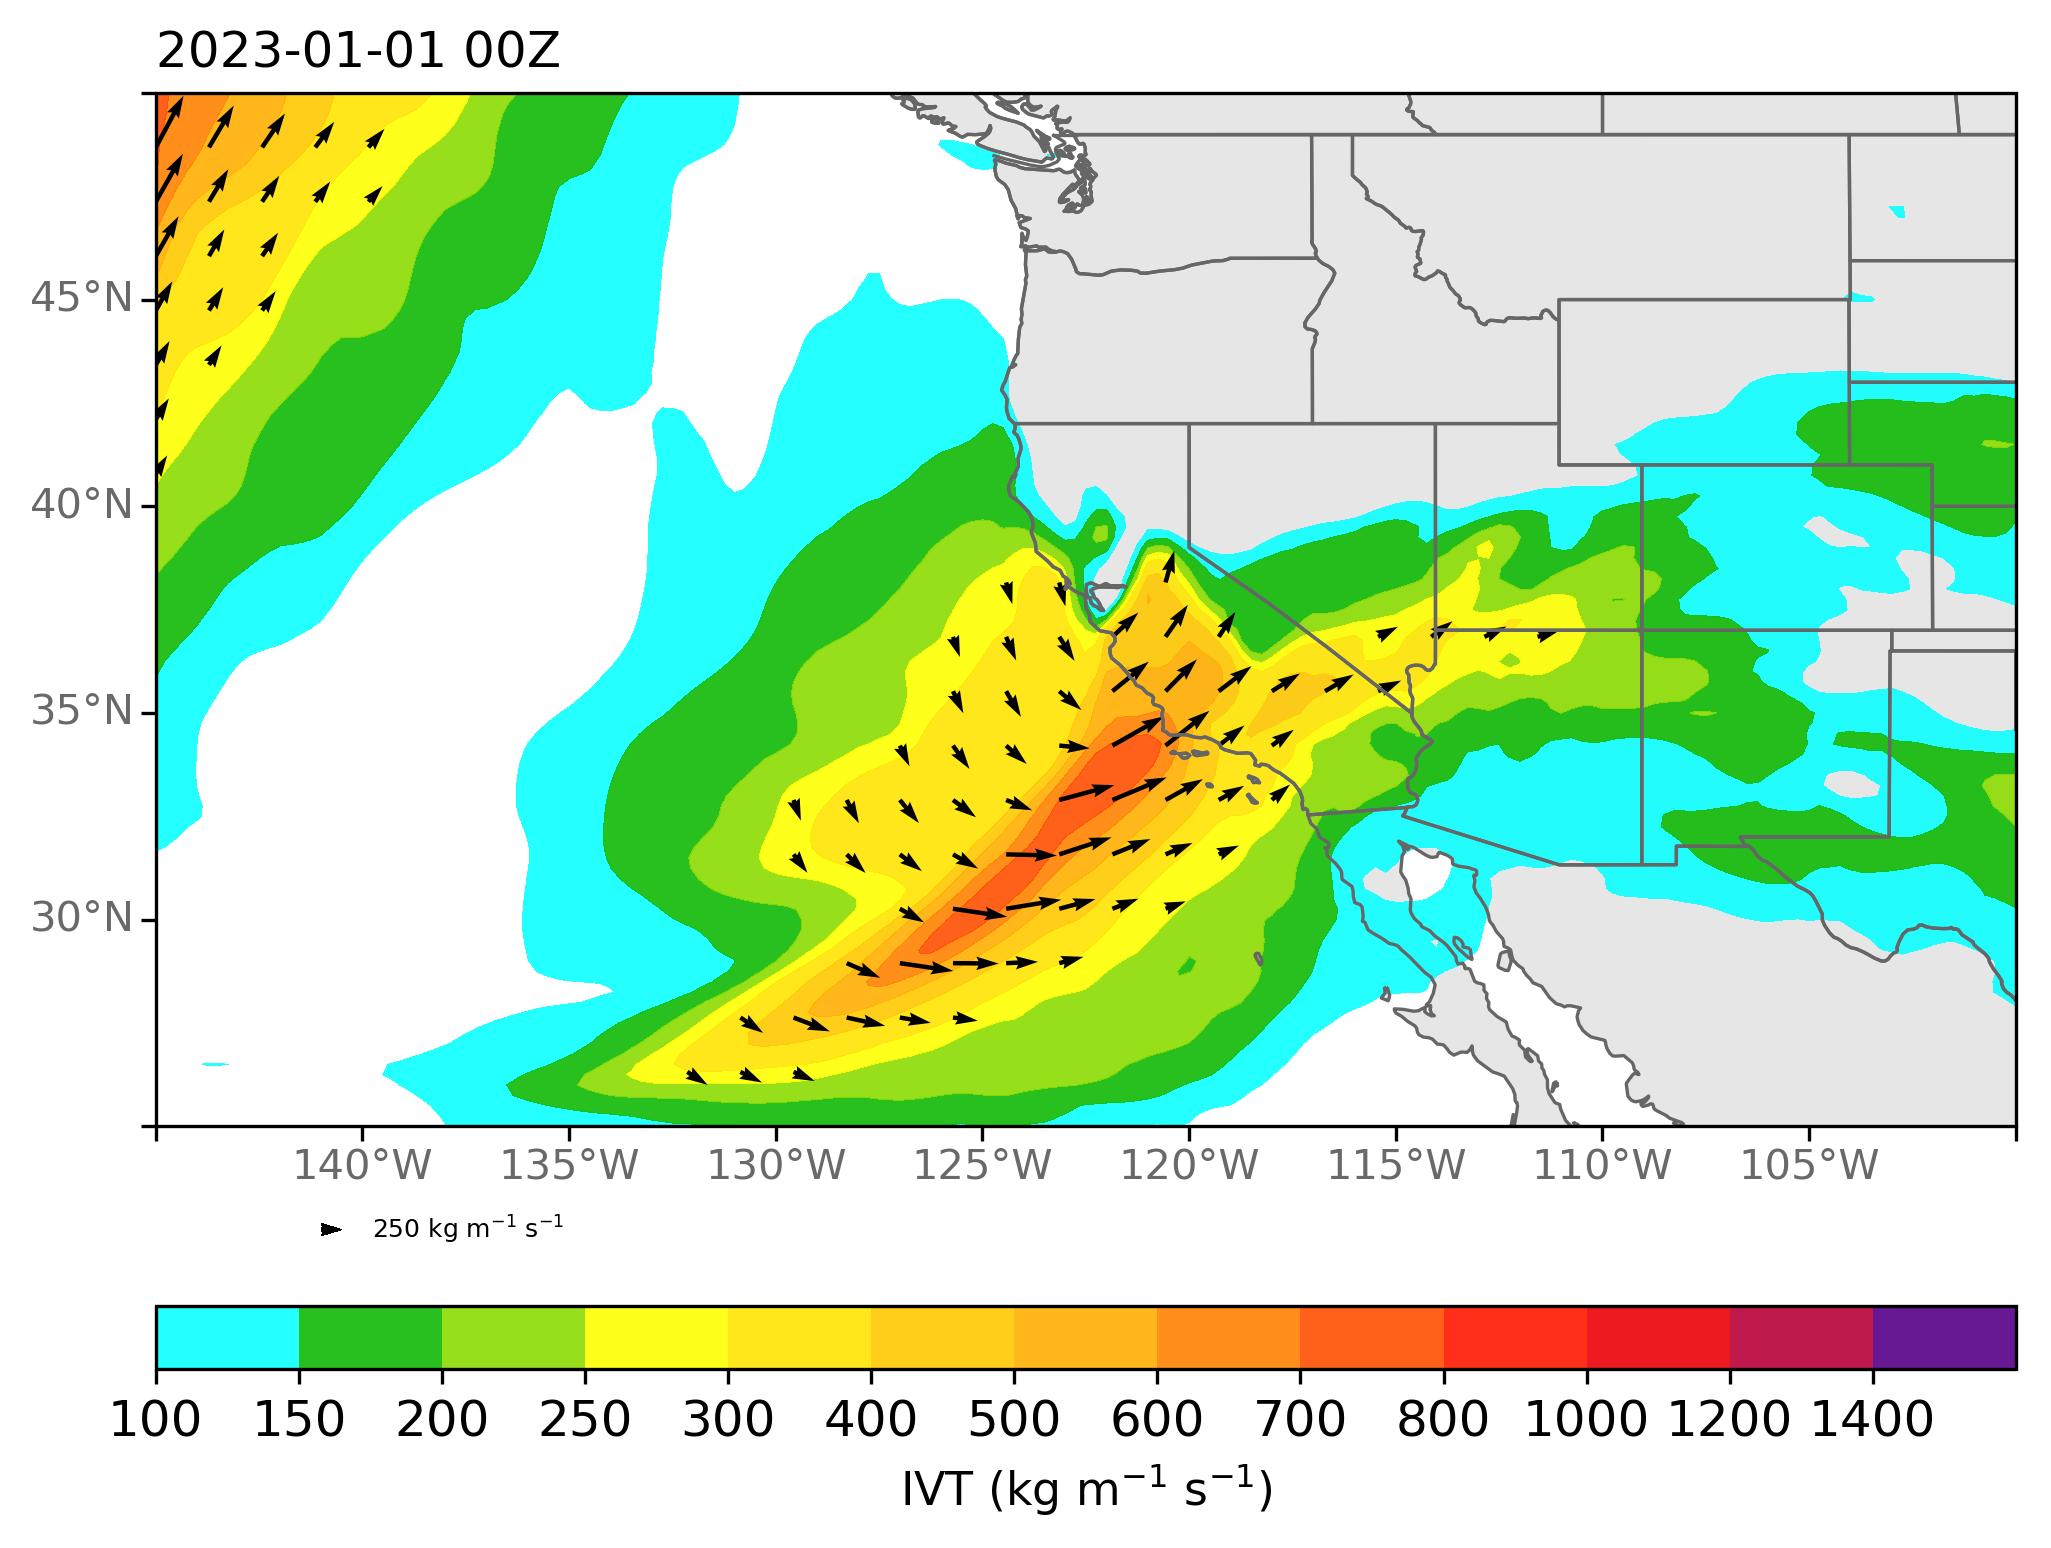

In [15]:
# Set up projection
datacrs = ccrs.PlateCarree()  ## the projection the data is in
mapcrs = ccrs.PlateCarree() ## the projection you want your map displayed in

ext1 = [-145., -100., 25, 50] # extent of interior west
dx1 = np.arange(ext1[0],ext1[1]+5,5)
dy1 = np.arange(ext1[2],ext1[3]+5,5)

# Create figure
fig = plt.figure(figsize=(8, 6))
fig.dpi = 300
fname = path_to_figs + 'case_study_dec2022'
fmt = 'png'

nrows = 3
ncols = 1

## Use gridspec to set up a plot with a series of subplots that is
## n-rows by n-columns
gs = GridSpec(nrows, ncols, height_ratios=[1, 0.02, 0.05], width_ratios = [1], wspace=0.05, hspace=0.05)
## use gs[rows index, columns index] to access grids

### plot IVT
ax = fig.add_subplot(gs[0, 0], projection=mapcrs)
ax = draw_basemap(ax, extent=ext1, xticks=dx1, yticks=dy1, left_lats=True, right_lats=False, bottom_lons=True, mask_ocean=False, coastline=True)
ax.add_feature(cfeature.STATES, edgecolor='0.4', linewidth=0.8)

ds = era.sel(time='2023-01-01 00')

t = pd.to_datetime(ds.time.values)
x_lbl = t.strftime('%Y-%m-%d %HZ')
ax.set_title(x_lbl, loc='left')

# Contour Filled
lats = ds.lat.values
lons = ds.lon.values
ivt = ds.IVT.values
cmap, norm, bnds = ccmap.cmap('ivt_intwest')
cf = ax.contourf(lons, lats, ivt, transform=datacrs,
                 levels=bnds, cmap=cmap, norm=norm, alpha=0.9, extend='neither')

# Wind barbs / vectors 
uvec = ds.uIVT.values
vvec = ds.vIVT.values
uvec_mask = ds.uIVT.where((ds.IVT >=250.)).values # mask values where IVT magnitude is less than 250 kg m-1 s-1
vvec_mask = ds.vIVT.where((ds.IVT >=250.)).values # mask values where IVT magnitude is less than 250 kg m-1 s-1

Q = ax.quiver(lons, lats, uvec_mask, vvec_mask, transform=datacrs, 
          color='k', regrid_shape=20,
          angles='xy', scale_units='xy', scale=500, units='xy')


    # ## Add trajectory  points
    # if (i > 0) & (i < 3):
    #     data = final_ds.isel(start_date=i-1)
    #     y_lst = data.lat.values
    #     x_lst = data.lon.values
    #     ax.plot(x_lst, y_lst, c='white', transform=datacrs, alpha=0.9)
    #     # cmap, norm, bnds = ccmaps.cmap('ivt')
    #     # cf = ax.scatter(x_lst, y_lst, c=z_lst, cmap=cmap, norm=norm, marker='.', transform=datacrs, alpha=0.8, s=30)

        
# quiver key
qk = ax.quiverkey(Q, 0.1, -0.1, 250, '250 kg m$^{-1}$ s$^{-1}$', labelpos='E',
                  coordinates='axes', fontproperties={'size': 6.0})
# Add color bar
cbax = plt.subplot(gs[-1,:]) # colorbar axis
cbarticks = bnds[0:-1:1] ## label every tick
cb = Colorbar(ax = cbax, mappable = cf, orientation = 'horizontal', ticklocation = 'bottom', ticks=cbarticks)
cb.set_label('IVT (kg m$^{-1}$ s$^{-1}$)', fontsize=11)
cb.ax.tick_params(labelsize=12)

fig.savefig('%s.%s' %(fname, fmt), bbox_inches='tight', dpi=fig.dpi)

# Show
plt.show()